Calculate a composites of your data based on a climate index other than Nino3.4 and plot maps of your composite.
If you already have a climate index you wish to use, you may use it.
If you need a climate index, a set of climate indices have been placed in the directory
/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/
These were obtained from NOAA/ESRL/PSL and the link gives you more information about the indices.
A sample notebook for how to read this data and turn into an xarray. Dataset is located here

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import dask
import xarray as xr
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as feature
from cartopy.util import add_cyclic_point

In [2]:
# Define the path to your zarr dataset
zarr_path = '/home/tsany/clim680_dataset/xBase_sliced_2004'

# Open the dataset using xarray
ds = xr.open_zarr(zarr_path)
ds

<xarray.Dataset>
Dimensions:   (time: 1093, lat: 3600, lon: 7200)
Coordinates:
  * lat       (lat) float64 89.97 89.92 89.88 89.83 ... -89.88 -89.92 -89.97
  * lon       (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time      (time) datetime64[ns] 2001-01-01T12:00:00 ... 2003-12-30T12:00:00
Data variables:
    ET_daily  (time, lat, lon) float32 dask.array<chunksize=(1093, 40, 40), meta=np.ndarray>

In [3]:
# Load indices 
file='/home/tsany/clim680_dataset/solar.data'
index_name='solar'

df=pd.read_table(file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(9).index,inplace=True)
df

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1948,1557,1343,1355,2081.0,2265.0,1955.0,1828.0,1728.0,1637.0,1591.0,1654.0,1933.0
1949,1835,2202,2039,1825.0,1549.0,1575.0,1599.0,1752.0,1725.0,1782.0,1804.0,1652.0
1950,1507,1433,1378,1643.0,1571.0,1287.0,1341.0,1209.0,986.0,999.0,1019.0,1011.0
1951,1079,1019,1025,1271.0,1686.0,1617.0,1163.0,1098.0,1178.0,1060.0,1044.0,1024.0
1952,954,862,785,840.0,809.0,848.0,888.0,933.0,815.0,828.0,834.0,857.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,700,720,684,700.0,709.0,725.0,697.0,691.0,683.0,695.0,689.0,700.0
2019,716,706,715,725.0,713.0,681.0,673.0,671.0,680.0,675.0,702.0,709.0
2020,723,709,702,696.0,692.0,697.0,695.0,717.0,706.0,746.0,901.0,873.0


In [4]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [5]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=900, freq='MS')

In [6]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')
# clim_index

In [7]:
ds_index=xr.DataArray(clim_index, coords={'time':dates}, dims=['time'])        
ds_index=ds_index.to_dataset(name='solar_flux').sel(time=slice('2001', '2003' ))
ds_index

<xarray.Dataset>
Dimensions:     (time: 36)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2003-12-01
Data variables:
    solar_flux  (time) float32 1.666e+03 1.467e+03 ... 1.408e+03 1.15e+03

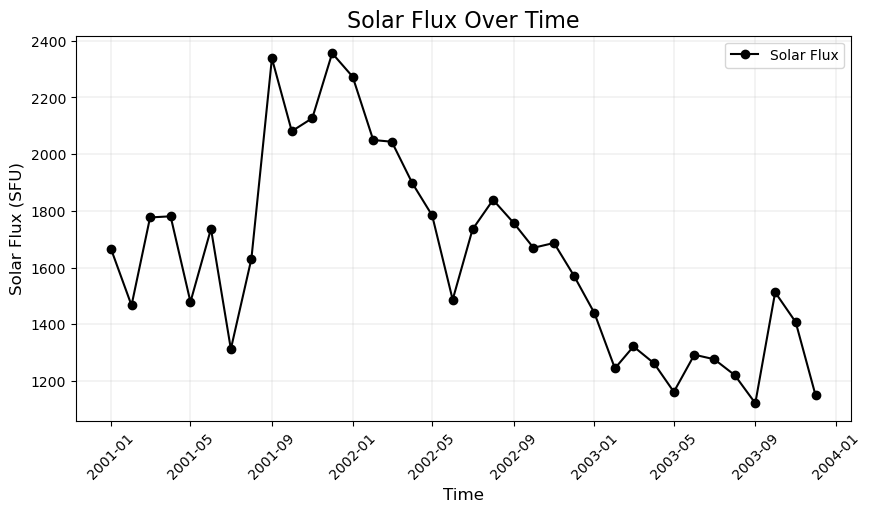

In [8]:
# Solar Flux Data
plt.figure(figsize=(10, 5))  
plt.plot(ds_index['time'], ds_index['solar_flux'], linestyle='-', marker='o', color='k')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Solar Flux (SFU)', fontsize=12)
plt.title('Solar Flux Over Time', fontsize=16)
plt.xticks(rotation=45)
plt.grid(linewidth=0.2)

plt.legend(['Solar Flux'])
plt.show()

In [9]:
# solar_flux.values

In [10]:
# Assigning Threshold
solar_flux = ds_index.solar_flux
threshold_high = solar_flux.quantile(0.75)
threshold_low = solar_flux.quantile(0.30)
mean = solar_flux.mean()
print(threshold_high.values, threshold_low.values, mean.values)

1797.75 1424.0 1637.9445


In [11]:
high_sol = solar_flux[solar_flux>threshold_high]
low_sol = solar_flux[solar_flux<threshold_low]

In [12]:
import matplotlib.dates as mdates
ds_index['mpl_time'] = mdates.date2num(ds_index['time'])

In [13]:
ds_index['solar_flux']

<xarray.DataArray 'solar_flux' (time: 36)>
array([1666., 1467., 1777., 1781., 1479., 1737., 1313., 1631., 2338.,
       2081., 2127., 2356., 2273., 2050., 2044., 1898., 1784., 1487.,
       1735., 1839., 1758., 1670., 1687., 1572., 1440., 1245., 1322.,
       1263., 1162., 1293., 1277., 1221., 1122., 1513., 1408., 1150.],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2003-12-01

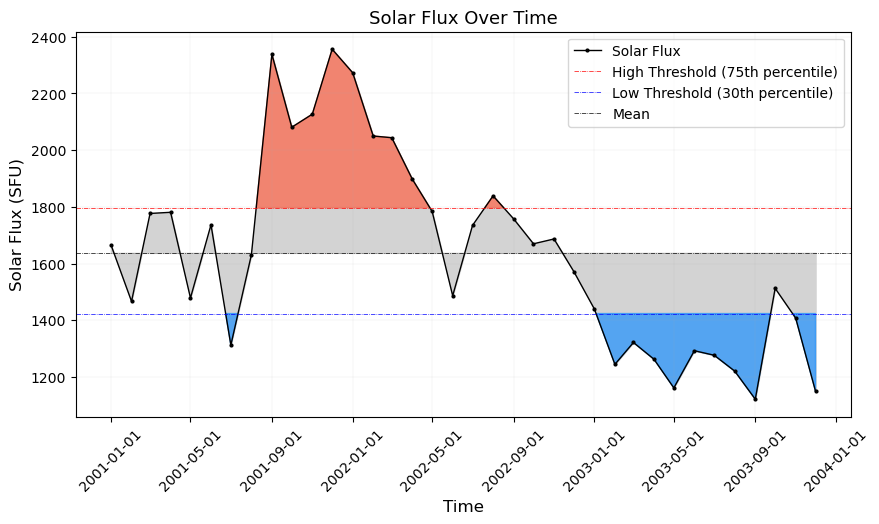

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(ds_index['mpl_time'], ds_index['solar_flux'], linestyle='-', linewidth=1, marker='o', markersize=2, color='k', label='Solar Flux')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Solar Flux (SFU)', fontsize=12)
plt.title('Solar Flux Over Time', fontsize=13)

plt.grid(linewidth=0.09)

# Convert 'mpl_time' for the x-axis.
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.axhline(threshold_high, color='red', linewidth=0.5, linestyle='-.', label='High Threshold (75th percentile)')
plt.axhline(threshold_low,  color='blue', linewidth=0.5, linestyle='-.', label='Low Threshold (30th percentile)')
plt.axhline(mean,  color='black', linewidth=0.5, linestyle='-.', label='Mean')

# 'mpl_time' for the x-axis data in fill_between.
plt.fill_between(ds_index['mpl_time'], mean, ds_index['solar_flux'], interpolate=True, color='lightgrey')
plt.fill_between(ds_index['mpl_time'], threshold_high, ds_index['solar_flux'], where=(ds_index['solar_flux'] >= threshold_high), interpolate=True, color='tomato', alpha=0.7)
plt.fill_between(ds_index['mpl_time'], threshold_low, ds_index['solar_flux'], where=(ds_index['solar_flux'] <= threshold_low), interpolate=True, color='dodgerblue', alpha=0.7)

plt.legend()
plt.show()

In [15]:
ds_index

<xarray.Dataset>
Dimensions:     (time: 36, mpl_time: 36)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2003-12-01
  * mpl_time    (mpl_time) float64 1.132e+04 1.135e+04 ... 1.236e+04 1.239e+04
Data variables:
    solar_flux  (time) float32 1.666e+03 1.467e+03 ... 1.408e+03 1.15e+03

In [16]:
high_index = solar_flux.where(solar_flux>threshold_high, drop=True)
low_index = solar_flux.where(solar_flux<threshold_low, drop=True)
neutral_index = solar_flux.where(
    (solar_flux <= threshold_high) & (solar_flux >= threshold_low), drop=True)

# Make the timesteps same as ds_anom
high_index['time']=high_index['time'].values.astype('datetime64[M]')
low_index['time']=low_index['time'].values.astype('datetime64[M]')
neutral_index['time']=neutral_index['time'].values.astype('datetime64[M]')


print(f'Neutral Timesteps: {len(neutral_index.time)}')
print(f'High Index Timesteps: {len(high_index.time)}')
print(f'Low Index Timesteps: {len(low_index.time)}')

Neutral Timesteps: 16
High Index Timesteps: 9
Low Index Timesteps: 11


In [18]:
# evaporation --> daily
ds_climo = ds.ET_daily.groupby('time.month').mean()
ds_anom = ds.ET_daily.groupby('time.month') - ds_climo
ds_anom

<xarray.DataArray 'ET_daily' (time: 1093, lat: 3600, lon: 7200)>
dask.array<getitem, shape=(1093, 3600, 7200), dtype=float32, chunksize=(32, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.97 89.92 89.88 89.83 ... -89.88 -89.92 -89.97
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 2001-01-01T12:00:00 ... 2003-12-30T12:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [19]:
high_index.time

<xarray.DataArray 'time' (time: 9)>
array(['2001-09-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2001-11-01T00:00:00.000000000', '2001-12-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', '2002-04-01T00:00:00.000000000',
       '2002-08-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2001-09-01 2001-10-01 ... 2002-08-01
    quantile  float64 0.75

In [20]:
# Resample the daily data to monthly averages
ds_anom_monthly = ds_anom.resample(time='M').mean()
ds_anom_monthly['time']= ds_anom_monthly['time'].values.astype('datetime64[M]')
ds_anom_monthly

<xarray.DataArray 'ET_daily' (time: 36, lat: 3600, lon: 7200)>
dask.array<stack, shape=(36, 3600, 7200), dtype=float32, chunksize=(1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2003-12-01
  * lat      (lat) float64 89.97 89.92 89.88 89.83 ... -89.88 -89.92 -89.97
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0

In [25]:
high_solar_evap = ds_anom_monthly.sel(time=high_index.dropna(dim='time')['time']).mean(dim='time')
low_solar_evap = ds_anom_monthly.sel(time=low_index.dropna(dim='time')['time']).mean(dim='time')
neutral_solar_evap = ds_anom_monthly.sel(time=neutral_index.dropna(dim='time')['time']).mean(dim='time')

In [26]:
high_solar_evap = high_solar_evap.compute()
low_solar_evap = low_solar_evap.compute()
neutral_solar_evap =neutral_solar_evap.compute()

In [29]:
print(np.nanmax(high_solar_evap.values))
print(np.nanmin(high_solar_evap.values))

0.06342213
-0.05200687


In [30]:
print(np.nanmax(low_solar_evap.values))
print(np.nanmin(low_solar_evap.values))

0.056197252
-0.058555923


In [31]:
print(np.nanmax(neutral_solar_evap.values))
print(np.nanmin(neutral_solar_evap.values))

0.027920675
-0.027997207


In [32]:
print(np.nanmean(high_solar_evap.values))

0.00017906538


Text(0.5, 0.98, 'Composite Evaporation Anomalies during Solar Flux Variation')

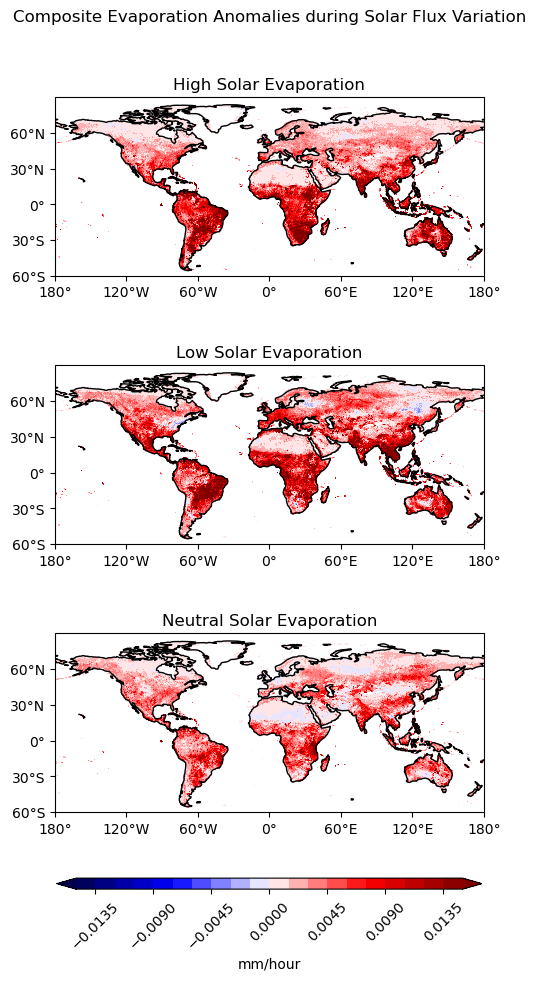

In [37]:
labels=['High Solar Evaporation','Low Solar Evaporation', 'Neutral Solar Evaporation']
clevs = np.linspace(-0.015, 0.015, 21)
comp_evap=[high_solar_evap, low_solar_evap, neutral_solar_evap]

fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

axs = axs.flatten()

#Loop over all of the seasons and plot
for i, evap in enumerate(comp_evap):

        data = comp_evap[i]
        data,lons = add_cyclic_point(data,coord=comp_evap[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_evap[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='seismic',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,61,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        axs[i].set_title(labels[i])
        axs[i].coastlines()
        axs[i].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
        
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.01]) # x-position, y-position, width, height
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/hour')
plt.setp(cbar.ax.get_xticklabels(), rotation=45)
plt.suptitle('Composite Evaporation Anomalies during Solar Flux Variation') 